# Routing for Social Good — OMMB Case Study 


**Author:** Data Science Team  

**Purpose:** Produce a polished, reproducible analysis that computes per-depot donation statistics, prioritizes depots for pickup, and proposes practical routing and scheduling decisions under operational constraints (freezer capacity ≈ 1,000 oz; single driver; 12-hour daily driving limit).



## Table of Contents
1. [Environment & Imports](#env)
2. [Load Data](#load)
3. [Data Cleaning & Normalization](#clean)
4. [Exploratory Data Analysis (EDA)](#eda)
   - Depot-level summaries
   - Distribution of daily fill rates
   - Top depots by daily volume
5. [Depot Prioritization & Classification](#prior)
6. [Routing Heuristic (Greedy TSP)](#route)
7. [Service Time & Weekly Schedule Estimation](#schedule)
8. [Operational Recommendations & Next Steps](#recommend)
9. [Appendix: Utility functions and tables](#appendix)


## 1) Environment & Imports <a name='env'></a>

Set up imports and plotting defaults.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import patches
import seaborn as sns
from typing import List, Tuple, Optional

sns.set_style('whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})


## 2) Load Data <a name='load'></a>

Load the transaction, depot, and driving distance datasets. Update file paths if needed.

In [ ]:
DEPOSIT_FILE = 'data/Deposits Transactions 2023 2024.xlsx'
DEPOT_FILE = 'data/Depot Information.xlsx'
DIST_FILE = 'data/Optional - Driving Distance and Time.xlsx'


trans_df = pd.read_excel(DEPOSIT_FILE)
depot_df = pd.read_excel(DEPOT_FILE)
dist_df = pd.read_excel(DIST_FILE)



In [109]:
depot_df.head(10)

,Notes,Region,Depot Designation,Depot Address
0,Added Depot,Bank,Oklahoma Mothers’ Milk Bank,"940 NE 13th St, Garrison Tower, Suite 1220, Ok..."
1,NaN,Local Depots,Integris Southwest,"4401 S Western Ave, OKC, OK 73109"
2,NaN,Local Depots,Integris Baptist,"3300 Northwest Expy, OKC, OK 73112"
3,NaN,Local Depots,Cleveland County Moore,"424 S Eastern Ave, Moore, OK 73160"
4,Added Depot,Local Depots,Variety Care- Lafayette,"500 SW 44th St., Oklahoma City, OK 73109"
5,Added ZIP,Local Depots,Edmond Hope Center,"1251 N Broadway, Edmond, OK 73034"
6,NaN,Local Depots,Canadian Valley,"1201 Health Center Parkway, Yukon, OK 73099"
7,NaN,Local Depots,St. Anthony Shawnee Hospital,"1102 W MacArthur St, Shawnee, OK 74804"
8,NaN,Local Depots,OU Children’s Hospital,"1200 Children’s Ave, OKC, OK 73104"
9,NaN,Tulsa Depots,OBI,"4601 E 81st St, Tulsa, OK 74137"


In [110]:
trans_df.head(10)

,Deposit ID,Deposit Date,Depo,Volume (oz)
0,1,2022-12-26,Oklahoma Mothers’ Milk Bank,150.00
1,17,2022-12-26,KUMC - Kansas Health Systems – St. Francis Campus,120.25
2,23,2022-12-26,Flint Hills- Riley County Health Department,142.79
3,17,2022-12-26,KUMC - Kansas Health Systems – St. Francis Campus,114.64
4,5,2022-12-26,Variety Care- Lafayette,135.91
5,21,2022-12-26,Salina Regional,125.77
6,7,2022-12-26,Canadian Valley,122.35
7,7,2022-12-26,Canadian Valley,131.72
8,37,2022-12-26,McAlester Regional Health,89.11
9,35,2022-12-26,Jackson County Altus,119.15


In [111]:
dist_df.head(10)

,Pair_key,Depot 1 Designation,Depot 2 Designation,Driving Time (minutes),Driving Distance (miles)
0,Oklahoma Mothers’ Milk Bank|Integris Southwest,Oklahoma Mothers’ Milk Bank,Integris Southwest,12.416667,6.7437
1,Oklahoma Mothers’ Milk Bank|Integris Baptist,Oklahoma Mothers’ Milk Bank,Integris Baptist,14.050000,8.8166
2,Oklahoma Mothers’ Milk Bank|Cleveland County M...,Oklahoma Mothers’ Milk Bank,Cleveland County Moore,19.383333,11.4450
3,Oklahoma Mothers’ Milk Bank|Variety Care- Lafa...,Oklahoma Mothers’ Milk Bank,Variety Care- Lafayette,13.200000,7.4378
4,Oklahoma Mothers’ Milk Bank|Edmond Hope Center,Oklahoma Mothers’ Milk Bank,Edmond Hope Center,20.933333,15.1602
5,Oklahoma Mothers’ Milk Bank|Canadian Valley,Oklahoma Mothers’ Milk Bank,Canadian Valley,22.433333,18.4752
6,Oklahoma Mothers’ Milk Bank|St. Anthony Shawne...,Oklahoma Mothers’ Milk Bank,St. Anthony Shawnee Hospital,38.433333,37.0138
7,Oklahoma Mothers’ Milk Bank|OU Children’s Hosp...,Oklahoma Mothers’ Milk Bank,OU Children’s Hospital,3.266667,0.5530
8,Oklahoma Mothers’ Milk Bank|OBI,Oklahoma Mothers’ Milk Bank,OBI,91.033333,105.0919
9,Oklahoma Mothers’ Milk Bank|Tulsa Hillcrest Ho...,Oklahoma Mothers’ Milk Bank,Tulsa Hillcrest Hospital,91.816667,105.5648


## 3) Data Cleaning & Normalization <a name='clean'></a>


In [112]:
QUOTE_CHAR = chr(8217)

def normalize_name(s: Optional[str]) -> Optional[str]:
    if pd.isna(s):
        return s
    return str(s).replace(QUOTE_CHAR, "'").strip()

if 'Depo' in trans_df.columns:
    trans_df['Depo'] = trans_df['Depo'].astype(str).apply(normalize_name)

for col in ['Depot Designation', 'Depot 1 Designation', 'Depot 2 Designation']:
    if col in depot_df.columns:
        depot_df[col] = depot_df[col].astype(str).apply(normalize_name)
    if col in dist_df.columns:
        dist_df[col] = dist_df[col].astype(str).apply(normalize_name)

if 'Deposit Date' in trans_df.columns:
    trans_df['Deposit Date'] = pd.to_datetime(trans_df['Deposit Date'])




## 4) Exploratory Data Analysis (EDA) <a name='eda'></a>

We begin with summary statistics and visualizations to understand the distribution of deposit volumes and identify high-impact depots.

### 4.1 Depot-level aggregation

Compute per-depot counts, total volumes, first/last deposit, days active, daily fill rate (oz/day), and estimated days to reach threshold capacity (85% of 1000 oz).

In [113]:
CAPACITY = 1000
THRESHOLD = 0.85


depot_stats = (
    trans_df.groupby('Depo')
    .agg({
        'Volume (oz)': ['count', 'sum', 'mean'],
        'Deposit Date': ['min', 'max']
    })
)


depot_stats.columns = ['Num_Deposits', 'Total_Volume', 'Avg_Deposit', 'First_Date', 'Last_Date']
depot_stats = depot_stats.reset_index()

depot_stats['Days_Active'] = (depot_stats['Last_Date'] - depot_stats['First_Date']).dt.days.replace(0, 1)
depot_stats['Daily_Fill_Rate'] = depot_stats['Total_Volume'] / depot_stats['Days_Active']
depot_stats['Days_To_Threshold'] = (CAPACITY * THRESHOLD) / depot_stats['Daily_Fill_Rate']


depot_stats = depot_stats.sort_values('Daily_Fill_Rate', ascending=False).reset_index(drop=True)
depot_stats.head()


,Depo,Num_Deposits,Total_Volume,Avg_Deposit,First_Date,Last_Date,Days_Active,Daily_Fill_Rate,Days_To_Threshold
0,Variety Care- Lafayette,475,63059.40,132.756632,2022-12-26,2024-12-28,733,86.029195,9.880367
1,Oklahoma Mothers' Milk Bank,461,61501.98,133.409935,2022-12-26,2024-12-28,733,83.904475,10.130568
2,Cleveland County Moore,465,60052.29,129.144710,2022-12-27,2024-12-29,733,81.926726,10.375125
3,Edmond Hope Center,480,58162.60,121.172083,2022-12-28,2024-12-28,731,79.565800,10.682982
4,Integris Southwest,490,56650.01,115.612265,2022-12-28,2024-12-29,732,77.390724,10.983228


### 4.2 Distribution of Daily Fill Rates

Visualize the distribution of daily fill rates to understand spread and skew; this helps define reasonable pickup frequency buckets.

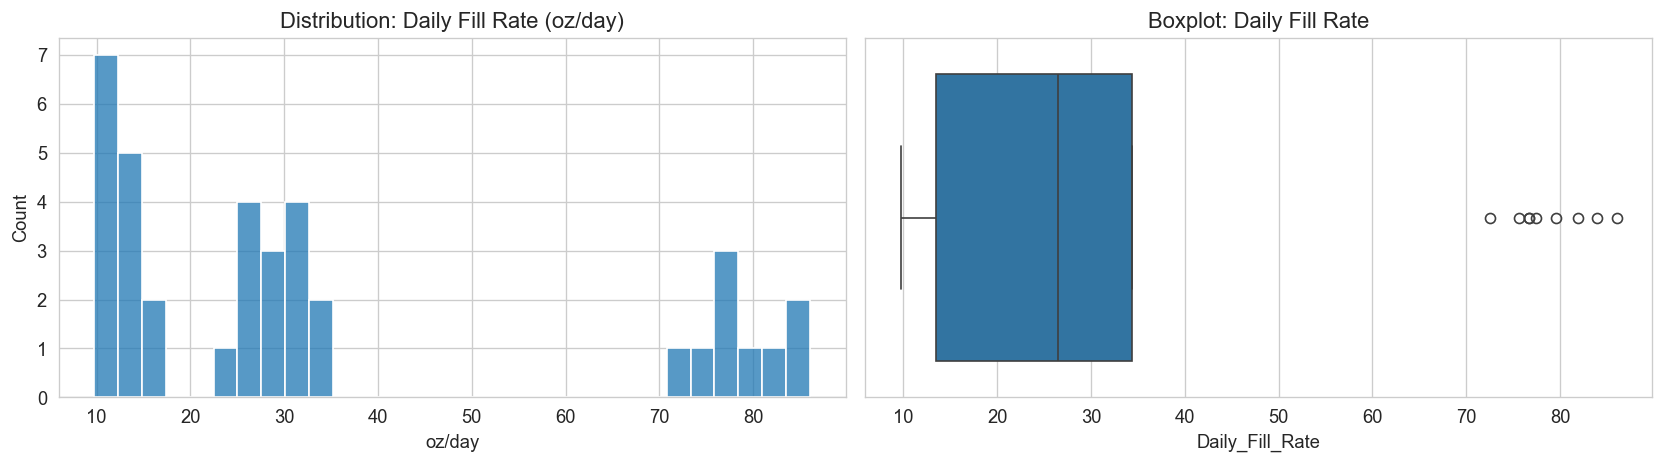

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(depot_stats['Daily_Fill_Rate'].dropna(), bins=30, ax=axes[0])
axes[0].set_title('Distribution: Daily Fill Rate (oz/day)')
axes[0].set_xlabel('oz/day')

sns.boxplot(x=depot_stats['Daily_Fill_Rate'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot: Daily Fill Rate')
plt.tight_layout()
plt.show()


### 4.3 Top 20 Depots by Daily Volume

Show the top 20 depots by daily fill rate with threshold line (50 oz/day) and short interpretation below the plot.

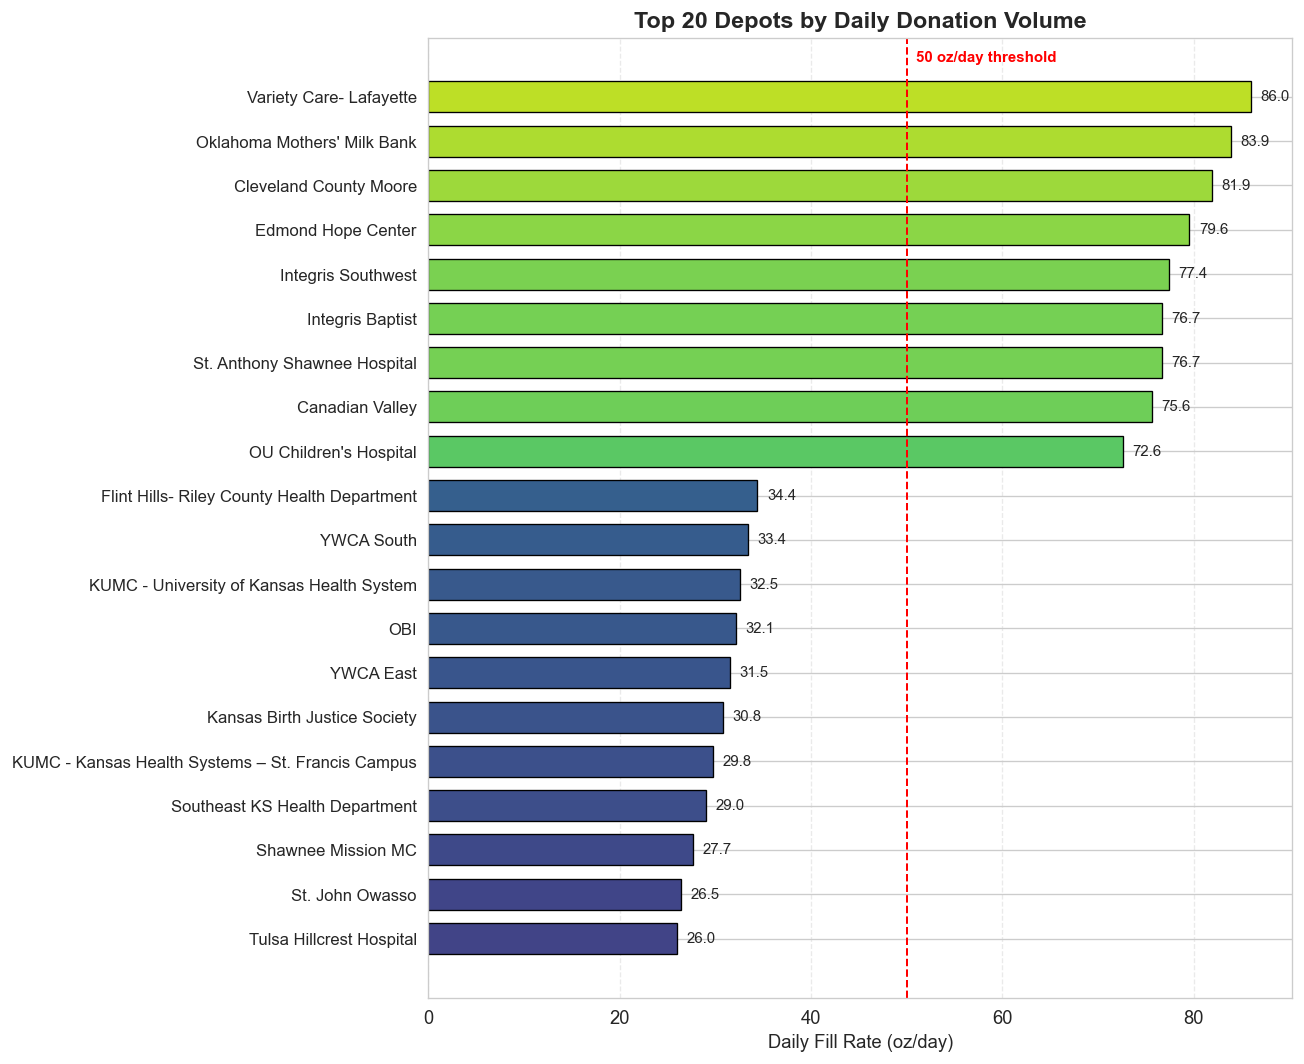

In [115]:
top_20 = depot_stats.head(20).copy()
import numpy as np
import matplotlib.ticker as mtick

y = np.arange(len(top_20))
values = top_20['Daily_Fill_Rate'].values
labels = top_20['Depo'].values

plt.figure(figsize=(11, 9))
ax = plt.gca()

cmap = plt.get_cmap('viridis')
range_val = np.ptp(values) if np.ptp(values) != 0 else 1
colors = cmap(0.2 + 0.7 * ((values - values.min()) / range_val))

bars = ax.barh(y, values, color=colors, edgecolor='black', linewidth=0.8, height=0.7)
for bar, val in zip(bars, values):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{val:,.1f}', va='center', ha='left', fontsize=9)

threshold_value = 50
ax.axvline(x=threshold_value, color='red', linestyle='--', linewidth=1.2)
ax.text(threshold_value + 1, -0.8, '50 oz/day threshold', color='red', fontsize=9, fontweight='semibold')

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=10)
ax.invert_yaxis()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Daily Fill Rate (oz/day)', fontsize=11)
ax.set_title('Top 20 Depots by Daily Donation Volume', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


**Interpretation (Top 20):**

- Depots to the right of the 50 oz/day threshold are high-priority for pickups.  
- Use `Days_To_Threshold` in `depot_stats` to convert these rates to estimated days until the freezer reaches the 85% threshold of capacity.  
- Consider weekly pickups for high-volume sites and less frequent rotations for low-volume sites.

## 5) Depot Prioritization & Classification <a name='prior'></a>

Merge depot metadata (Region) and classify depots into 'Pickup - Local', 'Pickup - Tulsa', or 'Ship'.

In [116]:
# Merge region info if available
if not depot_df.empty and 'Depot Designation' in depot_df.columns:
    depot_info = depot_df[['Depot Designation', 'Region']].copy()
    depot_info.columns = ['Depo', 'Region']
    depot_stats = depot_stats.merge(depot_info, on='Depo', how='left')
else:
    depot_stats['Region'] = None

def classify_method(region: Optional[str]) -> str:
    if region == 'Local Depots':
        return 'Pickup - Local'
    if region == 'Tulsa Depots':
        return 'Pickup - Tulsa'
    return 'Ship'

depot_stats['Method'] = depot_stats['Region'].apply(classify_method)

# display counts and a small table
method_counts = depot_stats['Method'].value_counts()
print('Method distribution:')
print(method_counts)
depot_stats[['Depo','Region','Method','Daily_Fill_Rate','Days_To_Threshold']].head()


Method distribution:
Method
Ship              23
Pickup - Local     8
Pickup - Tulsa     6
Name: count, dtype: int64


,Depo,Region,Method,Daily_Fill_Rate,Days_To_Threshold
0,Variety Care- Lafayette,Local Depots,Pickup - Local,86.029195,9.880367
1,Oklahoma Mothers' Milk Bank,Bank,Ship,83.904475,10.130568
2,Cleveland County Moore,Local Depots,Pickup - Local,81.926726,10.375125
3,Edmond Hope Center,Local Depots,Pickup - Local,79.565800,10.682982
4,Integris Southwest,Local Depots,Pickup - Local,77.390724,10.983228


### Method distribution (Pickup vs Ship)

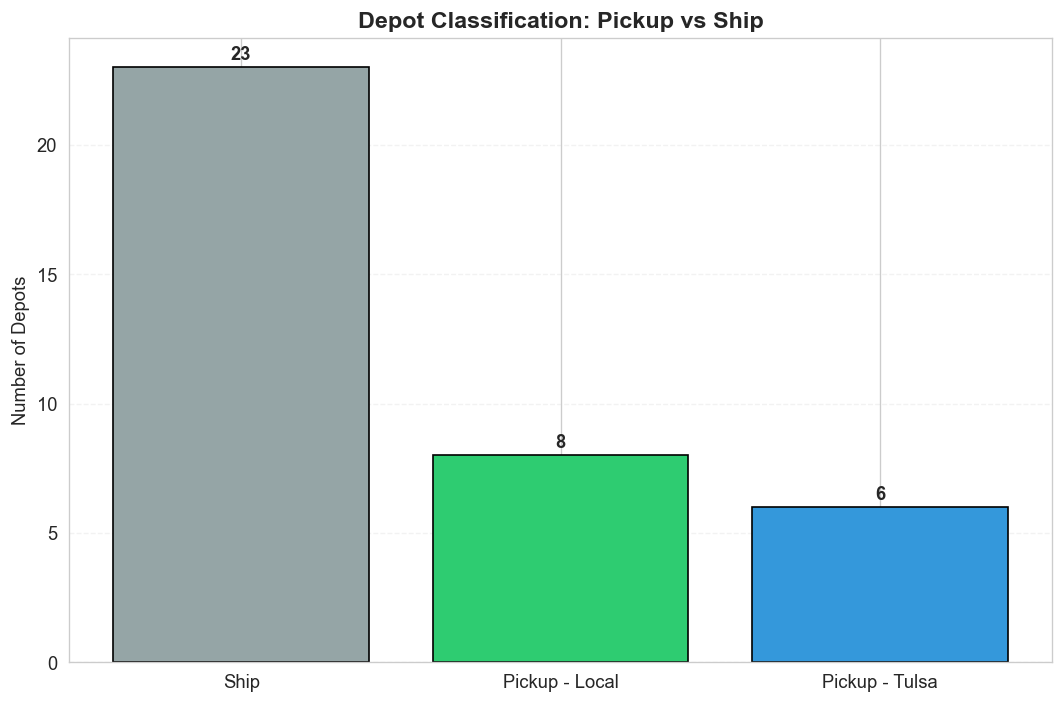

In [117]:
def plot_method_distribution(depot_stats: pd.DataFrame):
    method_counts = depot_stats['Method'].value_counts()
    palette = {'Pickup - Local': '#2ecc71', 'Pickup - Tulsa': '#3498db', 'Ship': '#95a5a6'}
    fig, ax = plt.subplots(figsize=(9, 6))
    bars = ax.bar(method_counts.index, method_counts.values,
                  color=[palette[m] for m in method_counts.index], edgecolor='black')
    for bar, v in zip(bars, method_counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{v}', ha='center', fontweight='bold')
    ax.set_ylabel('Number of Depots')
    ax.set_title('Depot Classification: Pickup vs Ship', fontsize=14, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_method_distribution(depot_stats)


## 6) Routing Heuristic (Greedy nearest-neighbor) <a name='route'></a>

Greedy TSP heuristic: starting at HQ, repeatedly visit the nearest unvisited depot, then return to HQ. This is a simple, fast heuristic suitable for the scale of this case study.

In [118]:
hq_name = "Oklahoma Mothers' Milk Bank"
MISSING_TIME_FALLBACK = 9999.0

def get_driving_time(a: str, b: str) -> float:
    if a == b:
        return 0.0
    row = dist_df[(dist_df['Depot 1 Designation'] == a) & (dist_df['Depot 2 Designation'] == b)]
    if not row.empty:
        return float(row.iloc[0]['Driving Time (minutes)'])
    row = dist_df[(dist_df['Depot 1 Designation'] == b) & (dist_df['Depot 2 Designation'] == a)]
    if not row.empty:
        return float(row.iloc[0]['Driving Time (minutes)'])
    return MISSING_TIME_FALLBACK

def solve_greedy_tsp(depots: List[str], start: str) -> Tuple[List[str], float]:
    route: List[str] = []
    unvisited = set(depots)
    current = start
    total = 0.0
    while unvisited:
        next_depot = min(unvisited, key=lambda d: get_driving_time(current, d))
        total += get_driving_time(current, next_depot)
        route.append(next_depot)
        current = next_depot
        unvisited.remove(next_depot)
    total += get_driving_time(current, start)
    return route, total

# Prepare depot lists
local_depots = [d.replace(QUOTE_CHAR, "'") for d in depot_stats.loc[depot_stats['Method']=='Pickup - Local','Depo'].tolist()]
tulsa_depots = [d.replace(QUOTE_CHAR, "'") for d in depot_stats.loc[depot_stats['Method']=='Pickup - Tulsa','Depo'].tolist()]

local_route, local_drive = solve_greedy_tsp(local_depots, HQ_NAME)
tulsa_route, tulsa_drive = solve_greedy_tsp(tulsa_depots, HQ_NAME)

print('Local route stops:', len(local_route), 'drive mins:', local_drive)
print('Tulsa route stops:', len(tulsa_route), 'drive mins:', tulsa_drive)


Local route stops: 8 drive mins: 189.46666666666667
Tulsa route stops: 6 drive mins: 309.2


### 6.1 Distance vs Volume (scatter)

Visualize whether nearby depots also tend to produce more (or less) volume. Highlight candidate depots that are both close and high-volume (good pickup efficiency).

In [119]:
hq_distances = dist_df[dist_df['Depot 1 Designation'].str.contains('Oklahoma Mothers', na=False)].copy()
hq_distances = hq_distances[['Depot 2 Designation', 'Driving Time (minutes)', 'Driving Distance (miles)']]
hq_distances.columns = ['Depo', 'Time_From_HQ', 'Distance_From_HQ']

depot_stats = depot_stats.merge(hq_distances, on='Depo', how='left')

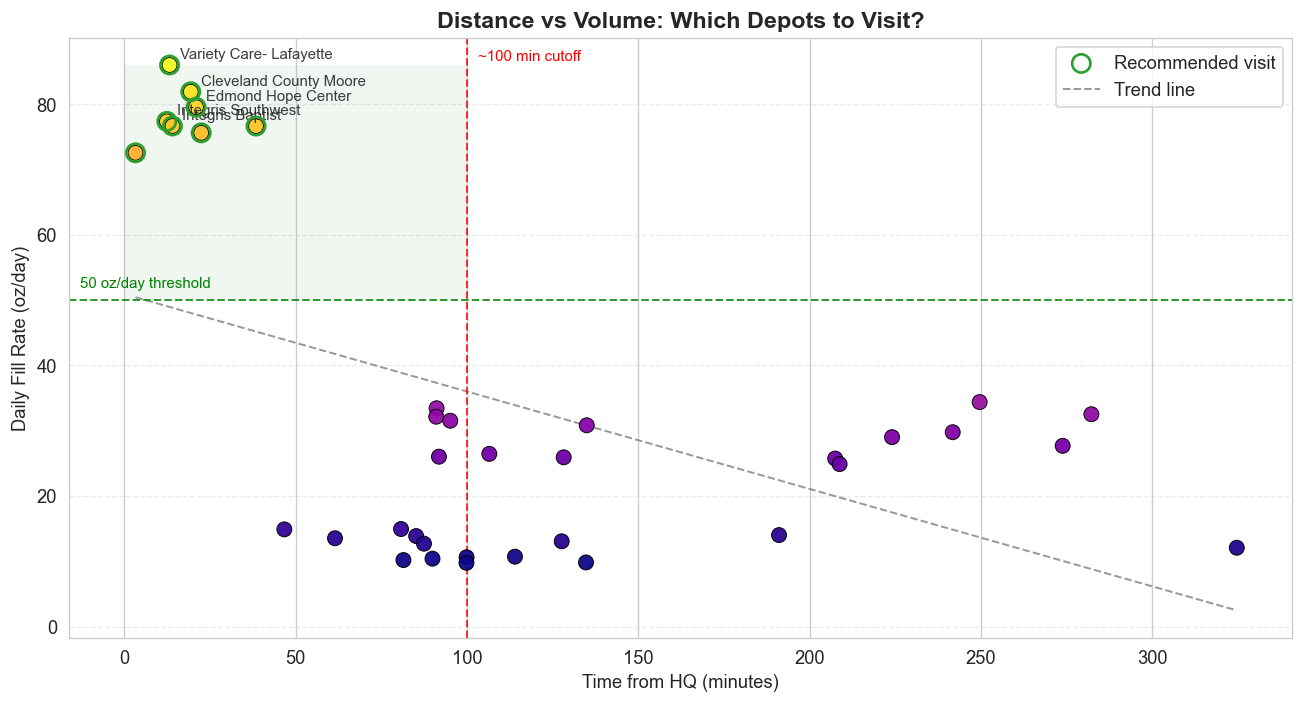

In [120]:
plot_data = depot_stats[depot_stats['Time_From_HQ'].notna()]

x = plot_data['Time_From_HQ'].values
y = plot_data['Daily_Fill_Rate'].values

THRESHOLD_TIME = 100
THRESHOLD_VOLUME = 50

plt.figure(figsize=(11, 6))
ax = plt.gca()

# Color points by Daily_Fill_Rate for visual gradient
cmap = plt.get_cmap('plasma')

range_val = np.ptp(y) if np.ptp(y) != 0 else 1
colors = cmap((y - y.min()) / range_val)

# Base scatter
scatter = ax.scatter(
    x, y,
    s=80,
    c=colors,
    edgecolor='black',
    linewidth=0.6,
    alpha=0.95,
    zorder=3
)

# Highlight "visit" candidates (time < THRESHOLD_TIME and volume > THRESHOLD_VOLUME)
mask_visit = (plot_data['Time_From_HQ'] < THRESHOLD_TIME) & (plot_data['Daily_Fill_Rate'] > THRESHOLD_VOLUME)
if mask_visit.any():
    ax.scatter(
        plot_data.loc[mask_visit, 'Time_From_HQ'],
        plot_data.loc[mask_visit, 'Daily_Fill_Rate'],
        s=120,
        facecolors='none',
        edgecolors='tab:green',
        linewidth=1.6,
        marker='o',
        zorder=4,
        label='Recommended visit'
    )


if len(x) >= 2:
    coeffs = np.polyfit(x, y, deg=1)
    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = np.polyval(coeffs, x_line)
    ax.plot(x_line, y_line, linestyle='--', linewidth=1.2, color='gray', alpha=0.8, label='Trend line')


roi = patches.Rectangle(
    (0, THRESHOLD_VOLUME),              
    THRESHOLD_TIME,                     
    y.max() - THRESHOLD_VOLUME,        
    linewidth=0,
    facecolor='green',
    alpha=0.06,
    zorder=1
)
ax.add_patch(roi)


ax.axvline(x=THRESHOLD_TIME, color='red', linestyle='--', alpha=0.8, linewidth=1.2)
ax.axhline(y=THRESHOLD_VOLUME, color='green', linestyle='--', alpha=0.8, linewidth=1.2)

ax.text(
    THRESHOLD_TIME + (x.max() - x.min()) * 0.01,
    ax.get_ylim()[1] * 0.98,
    f'~{THRESHOLD_TIME} min cutoff',
    color='red',
    fontsize=9,
    va='top'
)
ax.text(
    ax.get_xlim()[0] + (x.max() - x.min()) * 0.01,
    THRESHOLD_VOLUME + (y.max() - y.min()) * 0.02,
    f'{THRESHOLD_VOLUME} oz/day threshold',
    color='green',
    fontsize=9,
    va='bottom'
)

# Axis labels, title and formatting
ax.set_xlabel('Time from HQ (minutes)', fontsize=11)
ax.set_ylabel('Daily Fill Rate (oz/day)', fontsize=11)
ax.set_title('Distance vs Volume: Which Depots to Visit?', fontsize=14, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

# Improve tick formatting for readability
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Optional: annotate a few top candidates (by Daily_Fill_Rate) so chart doesn't get cluttered
top_candidates = plot_data.sort_values('Daily_Fill_Rate', ascending=False).head(5)
for _, row in top_candidates.iterrows():
    ax.annotate(
        row['Depo'] if 'Depo' in plot_data.columns else '',
        (row['Time_From_HQ'], row['Daily_Fill_Rate']),
        textcoords="offset points",
        xytext=(6, 4),
        fontsize=9,
        alpha=0.9
    )

# Legend and layout
ax.legend(frameon=True, loc='upper right')
plt.tight_layout()
plt.show()


## 7) Service Time & Weekly Schedule <a name='schedule'></a>

Estimate route durations including per-stop service time and produce a sample weekly schedule.

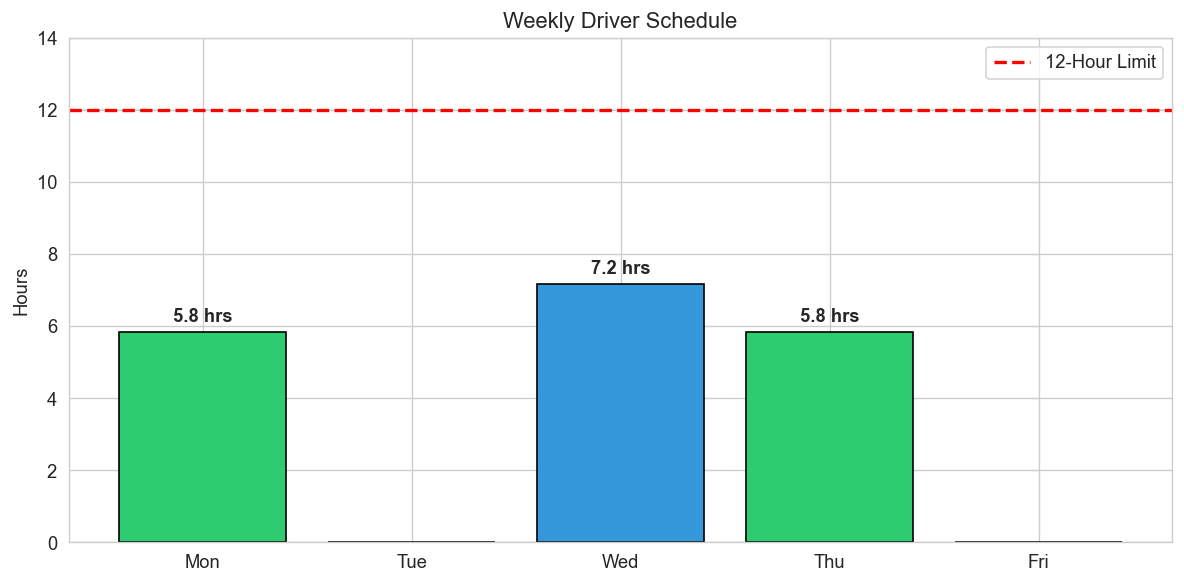


Weekly Total: 18.8 hours


In [121]:
SERVICE_TIME = 20

local_total = local_drive + len(local_depots) * SERVICE_TIME
tulsa_total = tulsa_drive + len(tulsa_depots) * SERVICE_TIME

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
hours = [local_total/60, 0, tulsa_total/60, local_total/60, 0]
labels = ['Local', 'Office', 'Tulsa', 'Local', 'Backup']
colors = ['#2ecc71', '#ecf0f1', '#3498db', '#2ecc71', '#ecf0f1']

plt.figure(figsize=(10, 5))
bars = plt.bar(days, hours, color=colors, edgecolor='black')
plt.axhline(y=12, color='red', linestyle='--', linewidth=2, label='12-Hour Limit')
plt.ylabel('Hours')
plt.title('Weekly Driver Schedule')
plt.ylim(0, 14)

for bar, label, h in zip(bars, labels, hours):
    if h > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{h:.1f} hrs', ha='center', fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

print(f"\nWeekly Total: {sum(hours):.1f} hours")

### We now have all the numbers we need for the report:

- MetricValueTotal depots : 37 (36 + HQ)
- Pickup depots: 14 (8 Local + 6 Tulsa)
- Shipping depots: 22 (8 Kansas + 14 Other)
- Local route time: 5.8 hrs (3.2 driving + 2.6 service)
- Tulsa route time: 7.2 hrs (5.2 driving + 2.0 service)
- Weekly driver hours: 18.8 hrs
- Local frequency: Twice weekly (Mon/Thu)
- Tulsa frequency: Weekly (Wed)

## 8) Candidate Routes (Greedy Heuristic)

Print ordered stop lists and driving times for Local and Tulsa runs.

In [122]:
def print_route(name, route, total_minutes):
    print(f"\n{name} ROUTE (greedy nearest-neighbor):")
    if route:
        for i, r in enumerate(route, 1):
            print(f"  {i:2d}. {r}")
    else:
        print('  (no stops)')
    print(f"Total driving time: {total_minutes:.1f} min ({total_minutes/60:.1f} hrs)")

print_route('LOCAL', local_route, local_drive)
print_route('TULSA', tulsa_route, tulsa_drive)



LOCAL ROUTE (greedy nearest-neighbor):
   1. OU Children's Hospital
   2. Integris Southwest
   3. Variety Care- Lafayette
   4. Cleveland County Moore
   5. Integris Baptist
   6. Canadian Valley
   7. Edmond Hope Center
   8. St. Anthony Shawnee Hospital
Total driving time: 189.5 min (3.2 hrs)

TULSA ROUTE (greedy nearest-neighbor):
   1. OBI
   2. YWCA South
   3. Tulsa Hillcrest Hospital
   4. YWCA East
   5. St. John Owasso
   6. Jane Phillips Medical Center
Total driving time: 309.2 min (5.2 hrs)


## Pyomo model

In [127]:
import pyomo.environ as pyo

local_nodes = [hq_name] + local_depots
n_local = len(local_nodes)

local_dist = {}
for i, d1 in enumerate(local_nodes):
    for j, d2 in enumerate(local_nodes):
        local_dist[i, j] = get_time(d1, d2)

print(f"Nodes: {n_local}")
for i, name in enumerate(local_nodes):
    print(f"  {i}: {name}")

Nodes: 9
  0: Oklahoma Mothers' Milk Bank
  1: Variety Care- Lafayette
  2: Cleveland County Moore
  3: Edmond Hope Center
  4: Integris Southwest
  5: Integris Baptist
  6: St. Anthony Shawnee Hospital
  7: Canadian Valley
  8: OU Children's Hospital


In [128]:
model = pyo.ConcreteModel()

model.N = pyo.RangeSet(0, n_local - 1)
model.x = pyo.Var(model.N, model.N, domain=pyo.Binary)
model.u = pyo.Var(model.N, domain=pyo.NonNegativeReals, bounds=(0, n_local - 1))

# Objective: minimize total travel time
def obj_rule(m):
    return sum(local_dist[i, j] * m.x[i, j] for i in m.N for j in m.N)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# Constraint: leave each node exactly once
def leave_rule(m, i):
    return sum(m.x[i, j] for j in m.N if j != i) == 1
model.leave = pyo.Constraint(model.N, rule=leave_rule)

# Constraint: enter each node exactly once
def enter_rule(m, j):
    return sum(m.x[i, j] for i in m.N if i != j) == 1
model.enter = pyo.Constraint(model.N, rule=enter_rule)

# Constraint: no self-loops
def no_self_rule(m, i):
    return m.x[i, i] == 0
model.no_self = pyo.Constraint(model.N, rule=no_self_rule)

# MTZ subtour elimination
def mtz_rule(m, i, j):
    if i != 0 and j != 0 and i != j:
        return m.u[i] - m.u[j] + n_local * m.x[i, j] <= n_local - 1
    return pyo.Constraint.Skip
model.mtz = pyo.Constraint(model.N, model.N, rule=mtz_rule)



In [129]:
solver = pyo.SolverFactory('glpk')
result = solver.solve(model, tee=False)

# Extract route
route = []
current = 0
for _ in range(n_local):
    for j in model.N:
        if j != current and pyo.value(model.x[current, j]) > 0.5:
            route.append(j)
            current = j
            break

print("OPTIMAL LOCAL ROUTE:")
print(f"  0: {local_nodes[0]} (Start)")
for i, idx in enumerate(route[:-1], 1):
    print(f"  {i}: {local_nodes[idx]}")
print(f"  {len(route)}: {local_nodes[0]} (Return)")

total_time = pyo.value(model.obj)
print(f"\nTotal driving time: {total_time:.1f} min ({total_time/60:.1f} hrs)")

OPTIMAL LOCAL ROUTE:
  0: Oklahoma Mothers' Milk Bank (Start)
  1: Edmond Hope Center
  2: Integris Baptist
  3: Canadian Valley
  4: Integris Southwest
  5: Variety Care- Lafayette
  6: Cleveland County Moore
  7: St. Anthony Shawnee Hospital
  8: OU Children's Hospital
  9: Oklahoma Mothers' Milk Bank (Return)

Total driving time: 167.8 min (2.8 hrs)


In [130]:
tulsa_nodes = [hq_name] + tulsa_depots
n_tulsa = len(tulsa_nodes)

tulsa_dist = {}
for i, d1 in enumerate(tulsa_nodes):
    for j, d2 in enumerate(tulsa_nodes):
        tulsa_dist[i, j] = get_time(d1, d2)

model2 = pyo.ConcreteModel()

model2.N = pyo.RangeSet(0, n_tulsa - 1)
model2.x = pyo.Var(model2.N, model2.N, domain=pyo.Binary)
model2.u = pyo.Var(model2.N, domain=pyo.NonNegativeReals, bounds=(0, n_tulsa - 1))

def obj_rule2(m):
    return sum(tulsa_dist[i, j] * m.x[i, j] for i in m.N for j in m.N)
model2.obj = pyo.Objective(rule=obj_rule2, sense=pyo.minimize)

def leave_rule2(m, i):
    return sum(m.x[i, j] for j in m.N if j != i) == 1
model2.leave = pyo.Constraint(model2.N, rule=leave_rule2)

def enter_rule2(m, j):
    return sum(m.x[i, j] for i in m.N if i != j) == 1
model2.enter = pyo.Constraint(model2.N, rule=enter_rule2)

def no_self_rule2(m, i):
    return m.x[i, i] == 0
model2.no_self = pyo.Constraint(model2.N, rule=no_self_rule2)

def mtz_rule2(m, i, j):
    if i != 0 and j != 0 and i != j:
        return m.u[i] - m.u[j] + n_tulsa * m.x[i, j] <= n_tulsa - 1
    return pyo.Constraint.Skip
model2.mtz = pyo.Constraint(model2.N, model2.N, rule=mtz_rule2)

solver.solve(model2, tee=False)

route2 = []
current = 0
for _ in range(n_tulsa):
    for j in model2.N:
        if j != current and pyo.value(model2.x[current, j]) > 0.5:
            route2.append(j)
            current = j
            break

print("OPTIMAL TULSA ROUTE:")
print(f"  0: {tulsa_nodes[0]} (Start)")
for i, idx in enumerate(route2[:-1], 1):
    print(f"  {i}: {tulsa_nodes[idx]}")
print(f"  {len(route2)}: {tulsa_nodes[0]} (Return)")

total_time2 = pyo.value(model2.obj)
print(f"\nTotal driving time: {total_time2:.1f} min ({total_time2/60:.1f} hrs)")

OPTIMAL TULSA ROUTE:
  0: Oklahoma Mothers' Milk Bank (Start)
  1: YWCA South
  2: Tulsa Hillcrest Hospital
  3: Jane Phillips Medical Center
  4: St. John Owasso
  5: YWCA East
  6: OBI
  7: Oklahoma Mothers' Milk Bank (Return)

Total driving time: 300.3 min (5.0 hrs)


## 9) Appendix & Utility functions <a name='appendix'></a>

Utility functions and helpful tables for export.

In [ ]:
# export prioritized depots
priority_table = depot_stats[['Depo','Region','Method','Daily_Fill_Rate','Days_To_Threshold']].copy()
priority_table = priority_table.sort_values('Daily_Fill_Rate', ascending=False)
priority_table.head(20)


,Depo,Region,Method,Daily_Fill_Rate,Days_To_Threshold
0,Variety Care- Lafayette,Local Depots,Pickup - Local,86.029195,9.880367
1,Oklahoma Mothers' Milk Bank,Bank,Ship,83.904475,10.130568
2,Cleveland County Moore,Local Depots,Pickup - Local,81.926726,10.375125
3,Edmond Hope Center,Local Depots,Pickup - Local,79.565800,10.682982
4,Integris Southwest,Local Depots,Pickup - Local,77.390724,10.983228
5,Integris Baptist,Local Depots,Pickup - Local,76.688131,11.083853
6,St. Anthony Shawnee Hospital,Local Depots,Pickup - Local,76.678338,11.085269
7,Canadian Valley,Local Depots,Pickup - Local,75.634687,11.238230
8,OU Children's Hospital,Local Depots,Pickup - Local,72.580861,11.711076
9,Flint Hills- Riley County Health Department,Kansas Depots,Ship,34.389168,24.717085


In [126]:
def get_time(depot_a: str, depot_b: str) -> float:
    """
    Return driving time in minutes between depot_a and depot_b.
    - If depot names are equal -> 0
    - Try direct (A,B) row, then (B,A) row.
    - If not found -> returns MISSING_TIME_FALLBACK to preserve original behavior.
    """
    if depot_a == depot_b:
        return 0.0

    # direct lookup (Depot 1 = A, Depot 2 = B)
    row = dist_df[
        (dist_df['Depot 1 Designation'] == depot_a) &
        (dist_df['Depot 2 Designation'] == depot_b)
    ]
    if not row.empty:
        return float(row.iloc[0]['Driving Time (minutes)'])

    # reverse lookup (Depot 1 = B, Depot 2 = A)
    row = dist_df[
        (dist_df['Depot 1 Designation'] == depot_b) &
        (dist_df['Depot 2 Designation'] == depot_a)
    ]
    if not row.empty:
        return float(row.iloc[0]['Driving Time (minutes)'])

    # fallback (keeps original behavior)
    return float(MISSING_TIME_FALLBACK)